In [3]:
import numpy as np
from lab2_proto import *
from lab2_tools import *
from prondict import prondict
import matplotlib.pyplot as plt

data = np.load('lab2_data.npz')['data']

one_speaker_model = np.load('lab2_models_onespkr.npz')
all_model = np.load('lab2_models_all.npz')
example = np.load('lab2_example.npz')["example"]
example.shape=(1,)
example = example[0]

def print_data_idx(data):
    for i in range(len(data)):
        print(i," ",data[i]["digit"])

        
print_data_idx(data)

0   o
1   o
2   z
3   z
4   1
5   1
6   2
7   2
8   3
9   3
10   4
11   4
12   5
13   5
14   6
15   6
16   7
17   7
18   8
19   8
20   9
21   9
22   o
23   o
24   z
25   z
26   1
27   1
28   2
29   2
30   3
31   3
32   4
33   4
34   5
35   5
36   6
37   6
38   7
39   7
40   8
41   8
42   9
43   9


In [4]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']


phoneHMMs = np.load('lab2_models_onespkr.npz')['phoneHMMs'].item()

wordHMMs = {}
for key in isolated.keys():
    wordHMMs[key] = concatHMMs(phoneHMMs, isolated[key])

In [17]:
    result = log_multivariate_normal_density_diag(example["lmfcc"],
                    wordHMMs['o']["means"],
                    wordHMMs['o']["covars"])
    print(np.sum(example["obsloglik"] - result))


-4.263256414560601e-14


(71, 9)
(97, 15)


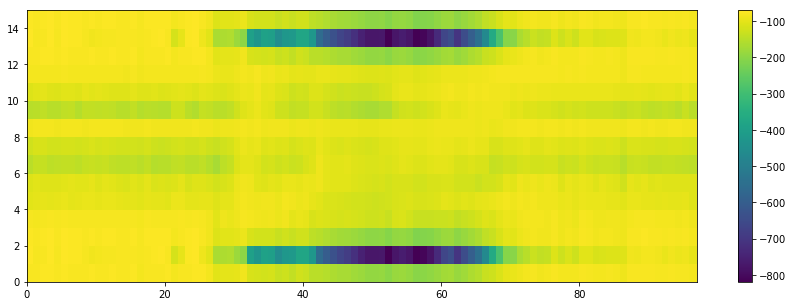

In [36]:
print(example["obsloglik"].shape)
print(result.shape)

plt.figure(figsize=(15,5))
plt.pcolormesh(result.T)
plt.colorbar()

plt.savefig("figures/obsloklik.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()

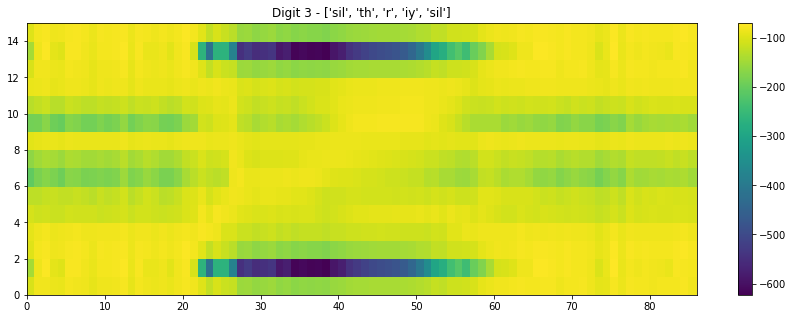

In [67]:
result_digit_3 = log_multivariate_normal_density_diag(data[30]["lmfcc"],
            wordHMMs['3']["means"],
            wordHMMs['3']["covars"])

plt.figure(figsize=(15,5))
plt.pcolormesh(result_digit_3.T)
plt.colorbar()

plt.title("Digit 3 - ['sil', 'th', 'r', 'iy', 'sil']")
plt.savefig("figures/obsloklik_3.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)


plt.show()

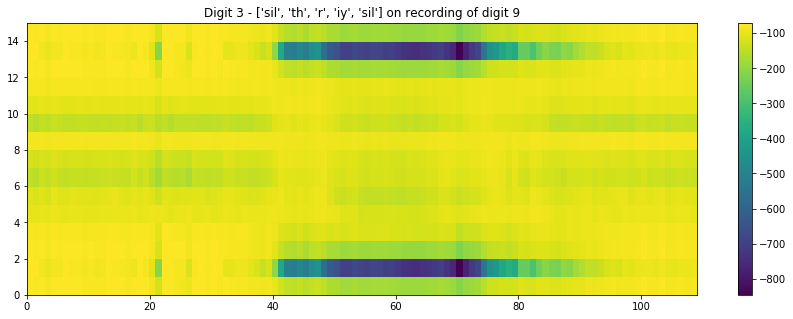

In [38]:
result_digit_9_model3 = log_multivariate_normal_density_diag(data[20]["lmfcc"],
            wordHMMs['3']["means"],
            wordHMMs['3']["covars"])

plt.figure(figsize=(15,5))
plt.pcolormesh(result_digit_9_model3.T)
plt.colorbar()

plt.title("Digit 3 - ['sil', 'th', 'r', 'iy', 'sil'] on recording of digit 9")
plt.savefig("figures/obsloklik_9_model3.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)


plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


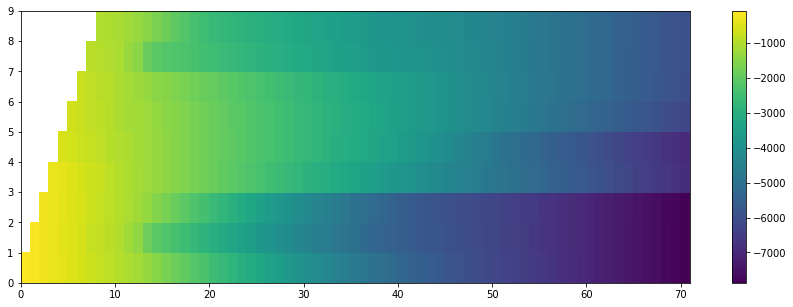

In [83]:
forward_prob = forward(example['obsloglik'],
        np.log(wordHMMs['o']["startprob"]),
        np.log(wordHMMs['o']["transmat"]))


plt.figure(figsize=(15,5))
plt.pcolormesh(forward_prob.T)
plt.colorbar()

plt.savefig("figures/forward_prob.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()

In [84]:
scores = np.zeros((44, 11))
for i in range(len(data)):
    data_ = data[i]["lmfcc"]

    j = 0
    for key, HMM in wordHMMs.items():
        data_log_lik = log_multivariate_normal_density_diag(
                data_, HMM["means"], HMM["covars"])
        fw = forward(data_log_lik,
                np.log(HMM["startprob"]),
                np.log(HMM["transmat"]))
        scores[i, j] = logsumexp(fw[-1, :])
        j += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


[ 0  0  1  1  4 10  4  3  4  4  5  5  4  4  7  7  4  4  4  4 10  1  0  0
  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


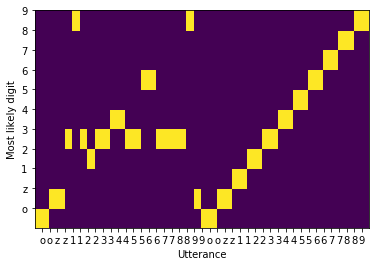

In [85]:
labels_hmm = []
labels_utterances = []
for k in wordHMMs.keys():
    labels_hmm.append(k)
    
for d in data:
    labels_utterances.append(d["digit"])

assignments = np.zeros((44, 11))

ass_index = np.argmax(scores, axis=1)
print(ass_index)

for i in range(44):
    assignments[i,ass_index[i]] = 1

plt.pcolormesh(assignments.T)
plt.ylabel("Most likely digit")
plt.yticks(range(1,12), labels=labels_hmm)
plt.xlabel("Utterance")
plt.xticks(range(1,44), labels=labels_utterances)
plt.savefig("figures/most_likely_one_model.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


In [64]:
# repeat with all models

phoneHMMsall = np.load('lab2_models_all.npz')['phoneHMMs'].item()
wordHMMsall = {}
for key in isolated.keys():
    wordHMMsall[key] = concatHMMs(phoneHMMsall, isolated[key])


In [65]:
scores = np.zeros((44, 11))
for i in range(len(data)):
    data_ = data[i]["lmfcc"]

    j = 0
    for key, HMM in wordHMMsall.items():
        data_log_lik = log_multivariate_normal_density_diag(
                data_, HMM["means"], HMM["covars"])
        fw = forward(data_log_lik,
                np.log(HMM["startprob"]),
                np.log(HMM["transmat"]))
        scores[i, j] = logsumexp(fw[-1, :])
        j += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10  0  0
  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9  2 10]


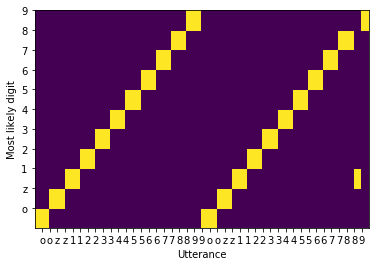

In [66]:
labels_hmm = []
labels_utterances = []
for k in wordHMMsall.keys():
    labels_hmm.append(k)
    
for d in data:
    labels_utterances.append(d["digit"])

assignments = np.zeros((44, 11))

ass_index = np.argmax(scores, axis=1)
print(ass_index)

for i in range(44):
    assignments[i,ass_index[i]] = 1

plt.pcolormesh(assignments.T)
plt.ylabel("Most likely digit")
plt.yticks(range(1,12), labels=labels_hmm)
plt.xlabel("Utterance")
plt.xticks(range(1,44), labels=labels_utterances)
plt.savefig("figures/most_likely_all_model.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


In [70]:
viterbi_loglik, viterbi_path = viterbi(example['obsloglik'],
        np.log(wordHMMs['o']["startprob"]),
        np.log(wordHMMs['o']["transmat"]))

print(viterbi_loglik)
print(example['vloglik'])


-5974.211288357338
-5974.211288357338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


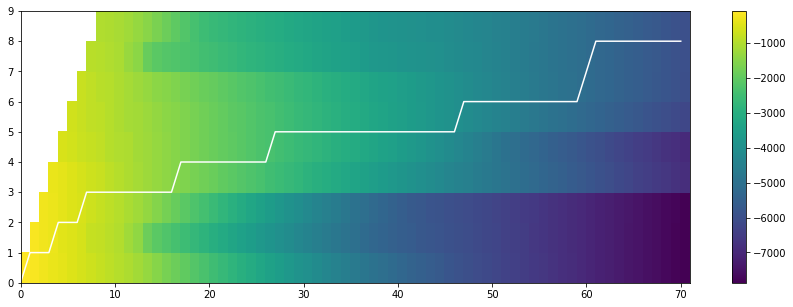

In [76]:


forward_prob = forward(example['obsloglik'],
        np.log(wordHMMs['o']["startprob"]),
        np.log(wordHMMs['o']["transmat"]))


plt.figure(figsize=(15,5))
plt.plot(viterbi_path,'-', color="w")

plt.pcolormesh(forward_prob.T)
plt.colorbar()
plt.savefig("figures/viterbi_path.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [93]:
scores_viterbi = np.zeros((44, 11))
for i in range(len(data)):
    data_ = data[i]["lmfcc"]

    j = 0
    for key, HMM in wordHMMs.items():
        data_log_lik = log_multivariate_normal_density_diag(
            data_, HMM["means"], HMM["covars"])
        viterbi_loglik, viterbi_path = viterbi(data_log_lik,
            np.log(HMM["startprob"]),
            np.log(HMM["transmat"]))
        scores_viterbi[i, j] = viterbi_loglik
        j += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


[ 0  0  1  1  4 10  4  3  4  4  5  5  4  4  7  7  4  4  4  4 10  1  0  0
  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


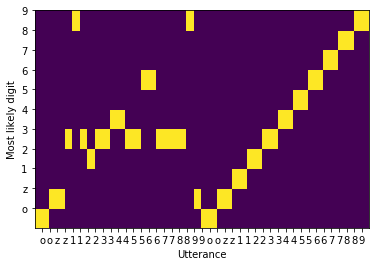

In [94]:

assignments = np.zeros((44, 11))

ass_index = np.argmax(scores_viterbi, axis=1)
print(ass_index)

for i in range(44):
    assignments[i,ass_index[i]] = 1

plt.pcolormesh(assignments.T)
plt.ylabel("Most likely digit")
plt.yticks(range(1,12), labels=labels_hmm)
plt.xlabel("Utterance")
plt.xticks(range(1,44), labels=labels_utterances)
plt.savefig("figures/most_likely_viterbi.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [90]:
scores_viterbi = np.zeros((44, 11))
for i in range(len(data)):
    data_ = data[i]["lmfcc"]

    j = 0
    for key, HMM in wordHMMsall.items():
        data_log_lik = log_multivariate_normal_density_diag(
            data_, HMM["means"], HMM["covars"])
        viterbi_loglik, viterbi_path = viterbi(data_log_lik,
            np.log(HMM["startprob"]),
            np.log(HMM["transmat"]))
        scores_viterbi[i, j] = viterbi_loglik
        j += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10  0  0
  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


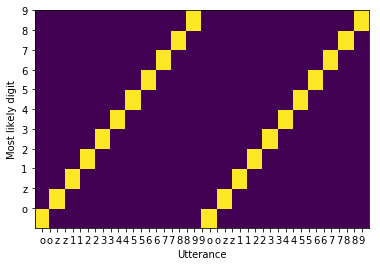

In [92]:

assignments = np.zeros((44, 11))

ass_index = np.argmax(scores_viterbi, axis=1)
print(ass_index)

for i in range(44):
    assignments[i,ass_index[i]] = 1

plt.pcolormesh(assignments.T)
plt.ylabel("Most likely digit")
plt.yticks(range(1,12), labels=labels_hmm)
plt.xlabel("Utterance")
plt.xticks(range(1,44), labels=labels_utterances)
plt.savefig("figures/most_likely_viterbiall.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


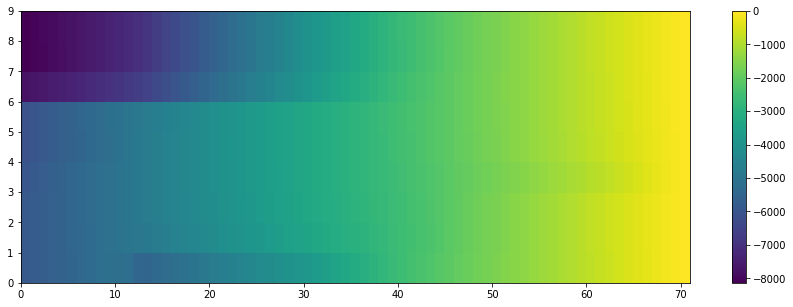

In [71]:
backward_prob = backward(example['obsloglik'],
        np.log(wordHMMs['o']["startprob"]),
        np.log(wordHMMs['o']["transmat"]))
plt.figure(figsize=(15,5))
plt.pcolormesh(backward_prob.T)
plt.colorbar()

plt.savefig("figures/backward_prob.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()

In [97]:
forward_prob = forward(example['obsloglik'],
        np.log(wordHMMs['o']["startprob"]),
        np.log(wordHMMs['o']["transmat"]))
backward_prob = backward(example['obsloglik'],
        np.log(wordHMMs['o']["startprob"]),
        np.log(wordHMMs['o']["transmat"]))
state_posterior = statePosteriors(forward_prob, backward_prob)

GMM_state_posterior = np.zeros(state_posterior.shape)
HMM = wordHMMs['o']
print(HMM["means"].shape)
GMM_state_posterior = log_multivariate_normal_density_diag(
       example['lmfcc'], HMM["means"], HMM["covars"])
for i in range(GMM_state_posterior.shape[0]):
    # normalize
    GMM_state_posterior[i, :] = GMM_state_posterior[i, :] - logsumexp(GMM_state_posterior[i, :])

print(np.sum(np.exp(GMM_state_posterior), axis = 1))

(9, 13)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


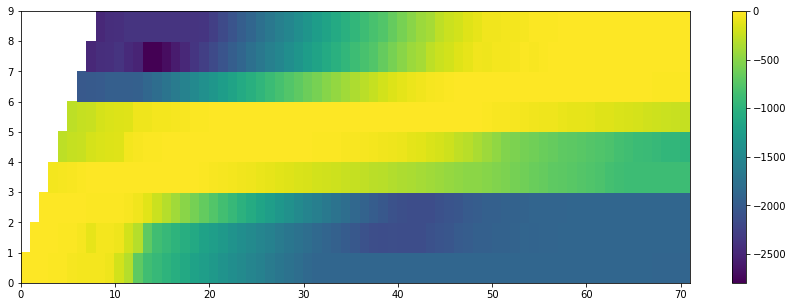

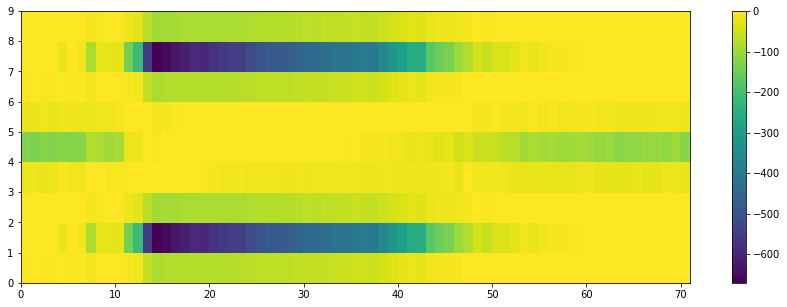

In [100]:
plt.figure(figsize=(15,5))
plt.pcolormesh(state_posterior.T)
plt.colorbar()

plt.savefig("figures/state_posterior.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()
plt.figure(figsize=(15,5))
plt.pcolormesh(GMM_state_posterior.T)
plt.colorbar()

plt.savefig("figures/GMM_posterior.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()

In [103]:
# summing up in the time domain
print(state_posterior.shape)

over_time = np.sum(np.exp(state_posterior), axis=0)
print("sum over time : ", over_time)
print("sum of the sum over time : ", np.sum(over_time))

(71, 9)
sum over time :  [ 1.346  2.096  3.558  9.738 10.12  20.533 12.997  1.209  9.404]
sum of the sum over time :  70.99999999991068


o
z


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


1
2
3
4
5
6
7
8
9


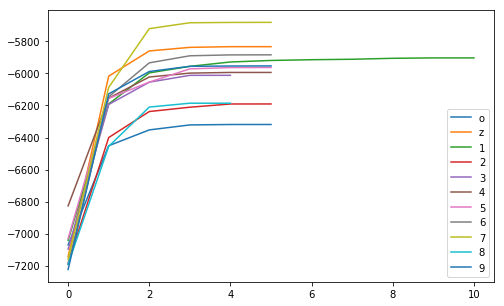

In [112]:
# update mean and variance

data_10 = data[10]
max_iters = 20
j = 0

Lik = np.zeros([max_iters, len(wordHMMsall.keys())])
Lik[:] = np.nan

for key, HMM in wordHMMsall.items():
    print(key)
    means = HMM["means"]
    covars = HMM["covars"]

    log_likelihood = +np.inf
    
    for i in range(max_iters):
        obs_log_lik = log_multivariate_normal_density_diag(data_10["lmfcc"],
                    means,
                    covars)

        forward_prob = forward(obs_log_lik,
                    np.log(HMM["startprob"]),
                    np.log(HMM["transmat"]))

        backward_prob = backward(obs_log_lik,
                np.log(HMM["startprob"]),
                np.log(HMM["transmat"]))

        log_likelihood_new = logsumexp(forward_prob[-1, :])
        Lik[i,j] = log_likelihood_new
        if abs(log_likelihood_new - log_likelihood) < 1:
            break

        log_likelihood = log_likelihood_new

        log_gamma = statePosteriors(forward_prob, backward_prob)

        means, covars = updateMeanAndVar(data_10["lmfcc"], log_gamma, varianceFloor=5.0)

    j += 1

    
plt.figure(figsize=(8,5))
plt.plot(Lik)

plt.legend(labels_hmm)

plt.savefig("figures/EM_gaussian.pdf",transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()